# Tree-Based Methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)

from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

## Fitting Classification Trees (과제에 사용)

우리는 먼저 Carseats 데이터셋을 분석하기 위해 분류 트리(classification tree)를 사용합니다.   
이 데이터에서 Sales는 연속형 변수이기 때문에, 우선 이 변수를 이진 변수로 변환합니다.   
np.where() 함수를 사용하여 Sales 값이 8을 초과하면 "Yes", 그렇지 않으면 "No"가 되도록 High라는 새로운 변수를 생성합니다.   


In [2]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")


이제 DecisionTreeClassifier()를 이용해 Sales를 제외한 모든 변수들을 사용하여 High를 예측하는 분류 트리를 적합하겠습니다.   
이를 위해 회귀 모델을 구성할 때처럼 모델 행렬(model matrix)을 만들어야 합니다.   

In [3]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

분류 트리를 설정할 때에는 몇 가지 주요 하이퍼파라미터를 지정해야 합니다.   
예를 들어 max_depth는 트리의 최대 깊이를 지정하고, min_samples_split은 분할을 수행하기 위해 필요한 최소 샘플 수를 지정합니다.   
또한 criterion은 분할 기준으로 Gini 지수나 엔트로피(entropy) 중 하나를 선택할 수 있습니다.   
분할 기준에서 동점이 발생할 경우를 대비해 random_state 값을 설정하여 결과를 재현 가능하게 합니다.   

In [6]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

sklearn에서 제공하는 DecisionTree에서는 원핫인코딩 필요 X

In [7]:
accuracy_score(High, clf.predict(X))

0.79

기본 설정만 사용한 경우, 학습 데이터에 대한 오차율(training error rate)은 약 21%입니다.

분류 트리(classification tree)에서 편차(deviance) 값을 계산하려면 log_loss() 함수를 사용할 수 있습니다.    
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
여기서 $n_{mk}$는 m번째 leaf node에 속한 sample 중 k번째 클래스에 속하는 개수이며, \hat{p}_{mk}는 해당 클래스에 대한 예측 확률입니ㅏㄷ.

In [9]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev
# 작으면 좋음

0.4710647062649358

시각화 직관적으로 가능!~

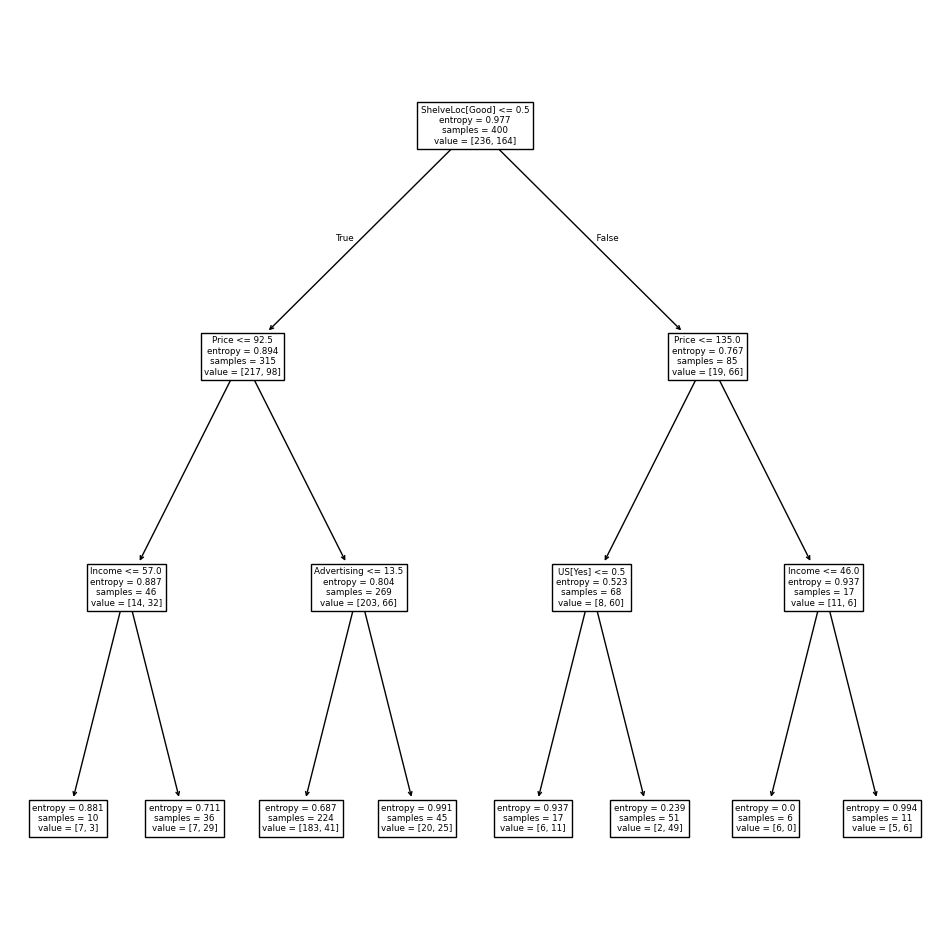

In [11]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


시각화 결과를 보면, Sales를 예측하는 데 가장 중요한 변수는 ShelveLoc으로 나타납니다.

In [12]:
# 다른 형식으로도 가능
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



CV

In [13]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']


array([0.685])

## Fitting Regression Trees

이번에는 Boston 데이터셋을 활용하여 회귀 트리(regression tree)를 적합해보겠습니다.   
전반적인 절차는 분류 트리를 만들 때와 매우 유사합니다.

In [14]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)


CV

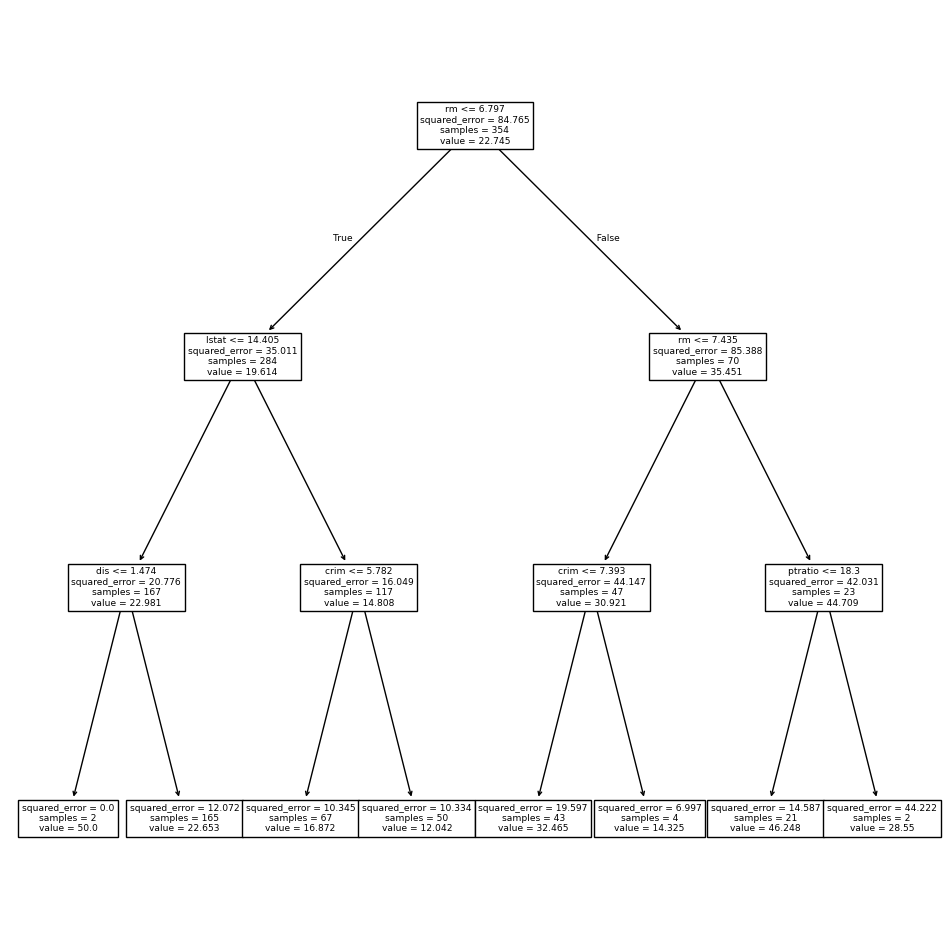

In [18]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);


여기서 lstat 변수는 저소득층 인구 비율을 의미합니다.   
트리를 보면 lstat 값이 작을수록 집값이 높은 경향을 보입니다.   
예를 들어, rm < 6.8, lstat > 14.4, **crim > 5.8**인 경우의 예측 중간 주택 가격은 약 12,042달러입니다.   

## Bagging and Random Forests

이번에는 Boston 데이터를 활용하여 배깅과 랜덤 포레스트를 적용해보겠습니다.   
sklearn.ensemble 패키지의 RandomForestRegressor()를 사용합니다.   

배깅은 랜덤 포레스트의 특수한 형태로, 분할 시 사용할 특성 수 m이 전체 특성 수 p와 같을 때 수행됩니다.   
즉, RandomForestRegressor()는 배깅과 랜덤 포레스트 둘 다 구현 가능합니다.   

In [19]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0) # bagging하겠다는 의미
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

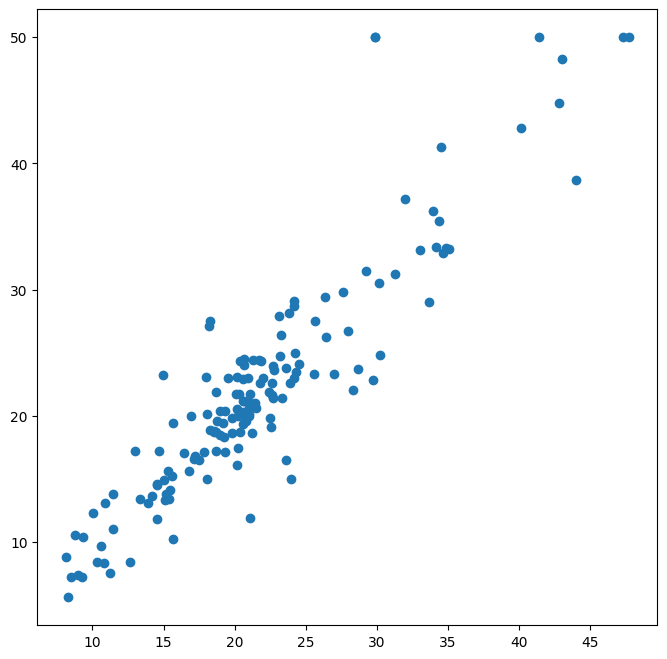

In [20]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


트리 개수 증가 후 재학습

In [21]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

트리 수(n_estimators)를 500개로 증가시켜도 성능에 큰 변화 없음   

이유: 배깅이나 랜덤 포레스트는 트리 개수를 늘려도 과적합되지 않지만, 너무 적으면 과소적합될 수 있음   

### Random Forest

In [23]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


20.04276446710527

변수 중요도 확인

In [24]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


모든 트리에서 노드 불순도 감소량을 기반으로 계산된 상대적 변수 중요도 

결과: 저소득층 비율(lstat)과 방 개수(rm)가 가장 중요한 변수로 나타남

## Boosting

이번에는 Boston 데이터셋에 부스팅 회귀 트리(Boosted Regression Trees) 를 적용해 보겠습니다.   
sklearn.ensemble의 GradientBoostingRegressor()를 사용하며, 분류 문제의 경우는 GradientBoostingClassifier()를 사용합니다.   

In [ ]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

n_estimators=5000: 트리 5000개 사용

learning_rate=0.001: 학습률 λ (작을수록 느리게, 안정적으로 학습)

max_depth=3: 각 트리의 깊이 제한

In [23]:
# 학습/테스트 에러 추이 시각화

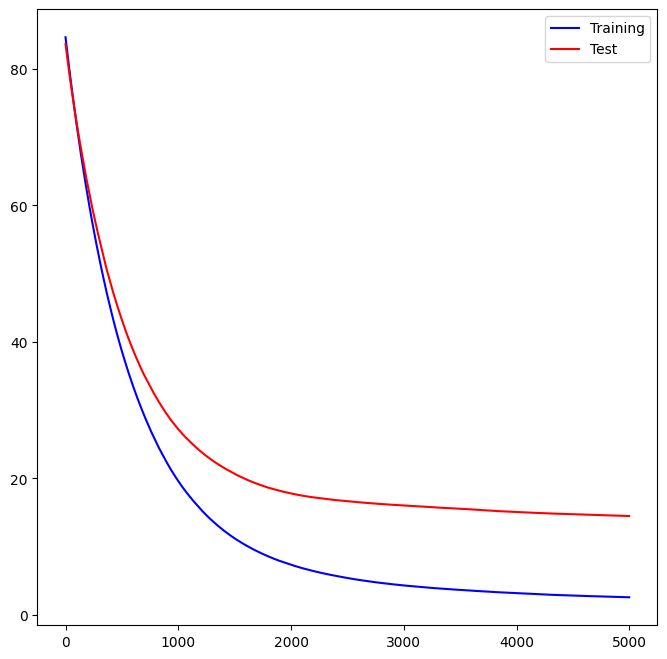

In [28]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();


MSE 계산

In [29]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.481405918831591

파라미터 학습률을 바꿔보기

In [30]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.501514553719565

비슷하다~

## Bayesian Additive Regression Trees

이번에는 BART 모델을 ISLP.bart 패키지를 이용하여 적용해 보겠습니다.   
BART는 정량적 반응 변수(회귀 문제)에 특화되어 있으며, 다른 구현체에서는 분류 모델(logit/probit 등)도 존재합니다.   

In [31]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15) # burnin=5, ndraw=15: MCMC 샘플링 파라미터
bart_boston.fit(X_train, y_train) 
# MCMC 샘플링 파라미터의 수치가 크면 오래걸립니다.

BART(burnin=5, ndraw=15, random_state=0)

In [32]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

In [33]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                          index=D.columns)

var_inclusion.sort_values(ascending=False)

lstat      31.000000
rm         29.800000
zn         27.866667
crim       26.933333
nox        26.600000
indus      26.466667
dis        26.466667
ptratio    24.266667
tax        24.133333
rad        23.666667
age        22.733333
chas       22.466667
dtype: float64

# HW (8장)

프로젝트 데이터에서 Decision Tree를 이용하여 `임신 성공 확률`을 예측하는데 주요한 요인을 시각화를 통해 찾고 해석하세요.

조건 트리 깊이는 2, 랜덤시드는 자신의 학번입니다.

In [34]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

# 데이터 경로 설정 및 불러오기
data_dir = os.path.join('/home/stat/KYH/dacon_6/SML_project', 'data')
train = pd.read_csv(os.path.join(data_dir, 'train.csv'), encoding='cp949').drop(columns='ID').dropna()
# 시각화를 위해 컬럼을 영어로 바꾸기
# 타깃값 이진 변환: '임신 성공 확률'을 boolean → int (0, 1)
column_translation = {
    '환자 시술 당시 나이': 'Patient Age at Procedure',
    '시술 유형': 'Procedure Type',
    '세부 시술 유형': 'Procedure Subtype',
    '배란 자극 시술 여부': 'Ovulation Stimulation Used',
    '단일 배아 이식 여부': 'Single Embryo Transfer',
    '불임 원인 - 난관 질환': 'Infertility - Tubal Factor',
    '불임 원인 - 배란 장애': 'Infertility - Ovulation Disorder',
    '불임 원인 - 남성 요인': 'Infertility - Male Factor',
    '불임 원인 - 자궁내막증': 'Infertility - Endometriosis',
    '불임 원인 - 불명확': 'Infertility - Unexplained',
    '이전 IVF 시술 횟수': 'Previous IVF Count',
    '이전 DI 시술 횟수': 'Previous DI Count',
    '이전 총 임신 횟수': 'Total Past Pregnancies',
    '이전 총 임신 성공 횟수': 'Total Past Successful Pregnancies',
    '총 생성 배아 수': 'Total Embryos Created',
    '이식된 배아 수': 'Embryos Transferred',
    '미세주입(ICSI) 배아 이식 수': 'ICSI Embryos Transferred',
    '저장된 배아 수': 'Embryos Frozen',
    '해동된 배아 수': 'Embryos Thawed',
    '해동 난자 사용 여부': 'Thawed Egg Used',
    '채취된 신선 난자 수': 'Fresh Eggs Retrieved',
    '신선 난자 사용 여부': 'Fresh Egg Used',
    '수정 시도된 난자 수': 'Eggs Attempted Fertilization',
    '난자 출처': 'Egg Source',
    '정자 출처': 'Sperm Source',
    '난자 기증자 나이': 'Egg Donor Age',
    '정자 기증자 나이': 'Sperm Donor Age',
    '동결 배아 사용 여부': 'Frozen Embryo Used',
    '신선 배아 사용 여부': 'Fresh Embryo Used',
    '기증 배아 사용 여부': 'Donated Embryo Used',
    '착상 전 PGD 시행 여부': 'Preimplantation PGD Performed',
    '착상 전 PGS 시행 여부': 'Preimplantation PGS Performed',
    '배아 이식 후 경과일': 'Days After Embryo Transfer',
    '임신 성공 확률': 'Target'
}

In [35]:
train.rename(columns=column_translation, inplace=True)

In [ ]:
# 범주형 변수 레이블 인코딩
encoded_train = train.copy()
label_encoders = {}
for col in encoded_train.columns:
    if encoded_train[col].dtype == 'object':
        le = LabelEncoder()
        encoded_train[col] = le.fit_transform(encoded_train[col])
        label_encoders[col] = le

# X, y 분리
X = encoded_train.drop(columns='Target')
y = encoded_train['Target']

# 이후 코드를 작성하는데 트리 깊이는 3, random_seed는 자신의 학번입니다.